In [12]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import itertools
import pandas as pd
import scipy.interpolate as inter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.signal as sig
import scipy.misc as misc
import scipy.integrate as integrate
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erfc
from sklearn.model_selection import train_test_split
pyo.init_notebook_mode()

def mintime(time):
    return 5*np.ceil(time/5.0)

def maxtime(time):
    return 5*np.floor(time/5.0)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

def partial_derivative2d(function, x, y, dx, dy):
    value1 = function(x-dx/2, y-dy/2)
    value2 = function(x+dx/2, y+dy/2)
    return (value2-value1)/np.sqrt(dx**2+dy**2)
    
def CloughTocher2d_interpolator(xref, yref, vals):
    """ 2d interpolation (requires Scipy).
     
    This is a convenience wrapper around
    scipy.interpolation.CloughTocher2Dinterpolator, that saves you
    having to worry about using meshgrid.
 
    Parameters
    ----------
    xref, yref : array of floats, shapes (J,), (I,)
      Reference coordinate grid. The grid must be equally spaced along
      each direction, but the spacing can be different between
      directions.
    vals : array of floats, shape (I, J)
      Reference values at the reference grid positions.
 
    Returns
    -------
    interpolator: CloughTocher2DInterpolater instance
      Object that accepts a (y,x) tuple (note reversed order from the
      input to this function!) and returns the interpolated value.
 
    See Also
    --------
    barak.plot.arrplot for plotting the reference and interpolated arrays.
    """
 
    assert (len(yref), len(xref)) == vals.shape
    XREF,YREF = np.meshgrid(xref, yref)
    
    interpolator = inter.CloughTocher2DInterpolator((XREF.ravel(), YREF.ravel()),
                                              vals.ravel())
 
    return interpolator

def constantfluxsurface(x, t, params):
    F0 = params[0]
    k = params[1]
    kappa = params[2]
    temps = 2*F0/2*((kappa*t/np.pi)**0.5*np.exp(-x/(4*kappa*t))-x/2*erfc(x/(2*kappa *t)**0.5))
    return temps

def residual(x, t, params, measured_temp):
    calculated_temps = consantfluxsurface(x, t, params)
    return temps - calculated_temps
    
    

    
order = 3
fs = 10.0   # sample rate, Hz
cutoff = 0.025# desired cutoff frequency of the filter, Hz



In [2]:
# load all the data into the script and plot a key temperature to decide the start and end of the heat flux experiment

target_folder = "C:/Users/jamen/Google Drive/Everything/Results/P1/HeatFlux Sensor/Processed//"

'''filenames = ["Conv150_1_1","Conv150_1_2","Conv150_2_1","Conv150_2_2","Conv150_3_1","Conv150_3_2","Conv150_4_1","Conv150_4_2",
"Conv150_6_1","Conv150_6_2",
"Conv250_1_1","Conv250_1_2","Conv250_2_1","Conv250_2_2","Conv250_3_1","Conv250_3_2","Conv250_4_1","Conv250_4_2","Conv250_6_1",
"Conv200_1_1","Conv200_1_2","Conv200_2_1","Conv200_3_1","Conv200_3_2","Conv200_4_1","Conv200_4_2","Conv200_6_1","Conv200_6_2",
"LowE200_1_1","LowE200_1_2","LowE200_2_1","LowE200_2_2","LowE200_3_1", "LowE200_3_2","LowE200_4_1","LowE200_4_2","LowE200_6_1","LowE200_6_2",
"LowE150_1_1","LowE150_1_2","LowE150_2_1","LowE150_2_2","LowE150_3_1", "LowE150_3_2","LowE150_4_1","LowE150_4_2","LowE150_6_1","LowE150_6_2"]'''

filenames = ["Conv150_1_1","Conv150_1_2","Conv150_2_1","Conv150_2_2","Conv150_3_1","Conv150_3_2","Conv150_4_1","Conv150_4_2",
"Conv150_6_1","Conv150_6_2",
"Conv200_1_1","Conv200_1_2","Conv200_2_1","Conv200_3_1","Conv200_3_2","Conv200_4_1","Conv200_4_2","Conv200_6_1","Conv200_6_2",
"LowE200_1_1","LowE200_1_2","LowE200_2_1","LowE200_2_2","LowE200_3_1", "LowE200_3_2","LowE200_4_1","LowE200_4_2","LowE200_6_1","LowE200_6_2",
"LowE150_1_1","LowE150_1_2","LowE150_2_1","LowE150_2_2","LowE150_3_1", "LowE150_3_2","LowE150_4_1","LowE150_4_2","LowE150_6_1","LowE150_6_2"]

dfs = []

test_TCs = ["T23RAW", "T19RAW"]
figs = []

for i in range(len(filenames)):
    '''figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]'''
    
    filename = filenames[i]
    df = pd.read_feather(target_folder+filename+'.feather')
    dfs.append(df)
    colors = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(test_TCs))))
    
    if filename[0:4] == "Conv":
        df["surface"] = "black"
        df["emissivity"] = 1.0
        df["ali thickness"] = 0.002
    else:
        df["surface"] = "polished"
        df["emissivity"] = 0.05
        df["ali thickness"] = 0.003
    df['jet temp'] = int(filename[4:7])
    df['position'] = int(filename[8])
    df['repeat'] = int(filename[10])
    df["ID"] = i
    '''for TC in test_TCs:
        c = next(colors)
        ax.plot(df["time"],df[TC], label = TC, color = c)
    ax.set_title(filenames[i]+" "+str(i))
    fig.legend()'''
#plt.show()

The above plot is used to ascertain the start and end of each of the heat flux experiments, this data is then inputted in the "start_ends" list below which crops the data to this range

In [3]:
i=0


start_ends = [[100,520],[80,410],
              [80,860],[80,860],
              [80,315],[85,415],
              [85,510],[75,755],
              [75,760],[100,600], 
              [80,215],[80,245],
              [50,180],[60,190],
              [55,190],[55,230],
             [70,250],[65,225],
             [75,275],
             [65,345],[75,320],
             [55,315],
             [80,370],[45,355],
              [80,1140],[30,400],
              [170,425],[70,340],
              [35,420],[85,450],
              [70,475],[70,565],
             [70,560], [80,515],
             [70,475], [65,675],
              [20,410],[110,500],
              [55,600],[25,480],
              [50,500],[30,600],
              [20,450],[20,720],
              [15,500],[60,790],
              [10,500],[25,460]]

start_ends = [[100,520],[80,410],
              [80,860],[80,860],
              [80,315],[85,415],
              [85,510],[75,755],
              [75,760],[100,600], 
              
             [65,345],[75,320],
             [55,315],
             [80,370],[45,355],
              [80,1140],[30,400],
              [170,425],[70,340],
              [35,420],[85,450],
              [70,475],[70,565],
             [70,560], [80,515],
             [70,475], [65,675],
              [20,410],[110,500],
              [55,600],[25,480],
              [50,500],[30,600],
              [20,450],[20,720],
              [15,500],[60,790],
              [10,500],[25,460]]


for i in range(len(dfs)):
    dfs[i]['time'] = dfs[i]['time'] - start_ends[i][0]
    dfs[i] = dfs[i][dfs[i]['time']<start_ends[i][1]-start_ends[i][0]]
    dfs[i] = dfs[i][dfs[i]['time']>=0]
    #dfs[i] = dfs[i].sort_index()

The flux data is calculated using a function copied from the master data processing script on github, flux and HTC columns are added to the dataframes

In [4]:
# copied from master processing script

import pandas as pd
import scipy.interpolate as inter
import scipy.integrate as integrate

def heat_flux_sensor_calculation(df, sensor_information, boundary_TC):

    for TC in sensor_information[1]:
        df[TC+' change'] = df[TC] - df.iloc[0][TC]    
    perspex_energy = []
    for time in df.index:
        temp_interp = inter.UnivariateSpline(sensor_information[0], 
                                             [df.at[time, x+' change'] for x in sensor_information[1]], s=0)
        perspex_energy.append(1190*1466*integrate.quad(temp_interp, a=0, b=0.02)[0])
    df['perspex energy'] = perspex_energy
    df['ali energy'] = df[sensor_information[1][0]+' change']*2710.0*910.0*df["ali thickness"]
    df['total energy'] = df['perspex energy']+df['ali energy']
    df['flux'] = df['total energy'].diff(1)/5.0
    df['HTC'] = df['flux']/(df[boundary_TC] - df[sensor_information[1][0]])
    return df


sensor_information = [[0.0, 0.005, 0.01, 0.015, 0.02], ['T19RAW', 'T18RAW', 'T20RAW', 'T16RAW', 'T17RAW']]
#                      location of TC in mm from the surface, name of TC
sensor_information = [[0.0, 0.005, 0.01, 0.015, 0.02], ['T19', 'T18', 'T20', 'T16', 'T17']]
boundary_TC = 'T23'# TC in air boundary layer
for df in dfs:
    df = heat_flux_sensor_calculation(df, sensor_information, boundary_TC)  

The processed data is combined into one dataset

In [5]:
alldata = pd.concat(dfs)

The flux data is then fitted to a function of flux,this can be editted in the "surface_flux" function.

Once fitted a "calc flux" column is added to the dataframe

Additionally a results list is created which stores the output from the fitting function

In [6]:
def surface_flux(df, sensor_information, boundary_TC):
    '''calculates the fitted convective and radiative fluxes into sensor, 
    returns a dataframe with those columns added'''
    df['fitted convective flux'] = df['fitted HTC']*(df[boundary_TC]-df[sensor_information[1][0]])
    df['fitted radiative flux'] = df["emissivity"]*5.670373*10**-8*\
    ((df['BB temp']+273.15)**4.0-(df[sensor_information[1][0]]+273.15)**4.0)
    df['fitted surface flux'] = df['fitted convective flux'] + df['fitted radiative flux']
    return df

def assign_parameters(params, df, test_temps):
    '''Inputs the fitting parameters into the dataframe'''
    df['fitted HTC'] = params[0]
    for i in range(len(test_temps)):
        temp = test_temps[i]
        BB_temp = params[i+1]
        df.loc[df['jet temp']==temp, 'BB temp'] = BB_temp
    return df
    

def residual(params, df, sensor_information, boundary_TC, flux, test_temps):
    df = assign_parameters(params, df, test_temps)
    df = surface_flux(df, sensor_information, boundary_TC)
    return np.sum((df['fitted surface flux'] - df[flux])**2.0)

def fitting_wrapper(df, sensor_information, boundary_TC, flux, test_temps):
    x0 = [30] + [180]*len(test_temps)
    bounds = [[0, 100]] + [[100,350]]*len(test_temps)
    result = opt.minimize(residual, x0, args=(df, sensor_information, boundary_TC, flux, test_temps), bounds=bounds)
    df = assign_parameters(result.x, df, test_temps)
    df = surface_flux(df, sensor_information, boundary_TC)
    return result, df

positions = alldata['position'].drop_duplicates().tolist()

results = []
dfs = []
for position in positions:
    test_set = alldata[alldata['position']==position]
    test_temps = test_set['jet temp'].drop_duplicates().tolist()
    result, df = fitting_wrapper(test_set, sensor_information, boundary_TC, 'flux', test_temps)
    results.append(result)
    dfs.append(df)
alldata = pd.concat(dfs)

Printing results from the function fitting

In [7]:
for i in range(len(positions)):
    name = positions[i]
    res = results[i].x
    print(name, res)

1 [ 34.42884975 113.43540836 151.02756984]
2 [ 33.32503507 120.27517305 171.74209129]
3 [ 29.64671091 126.8316876  164.24253791]
4 [ 24.73482853 122.33983383 149.25672079]
6 [ 36.65258178 136.49607503 182.84246716]


Plotting for comparing caulcated / fitted heat fluxes with mesaured heat fluxes

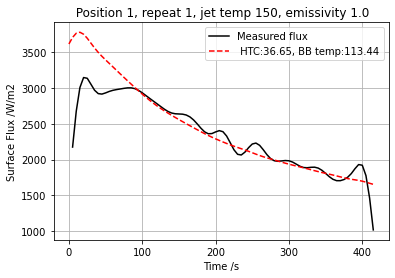

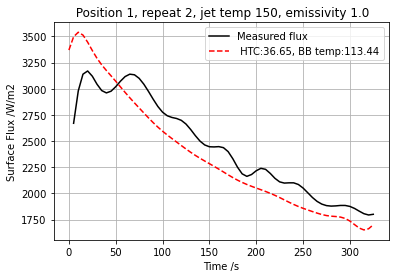

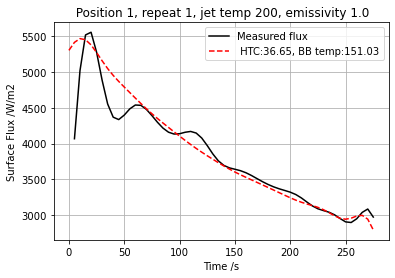

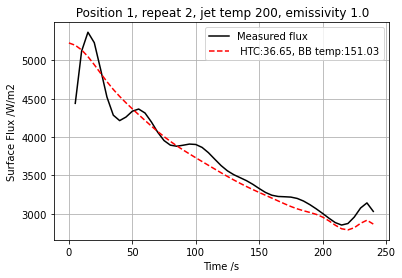

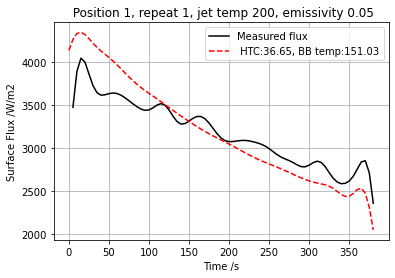

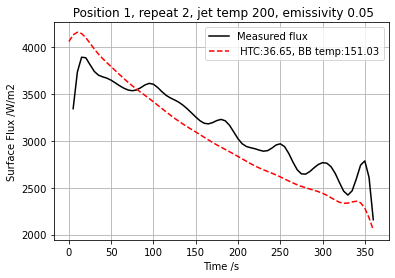

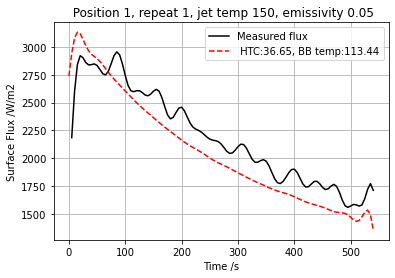

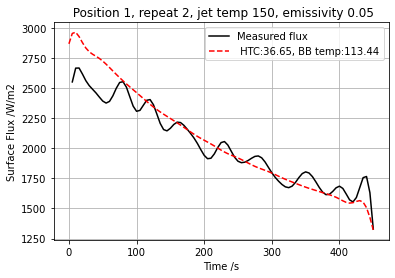

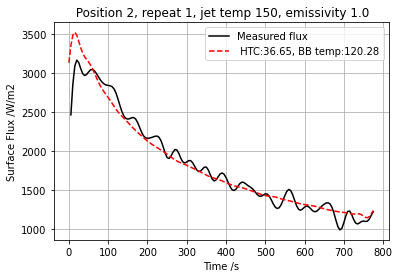

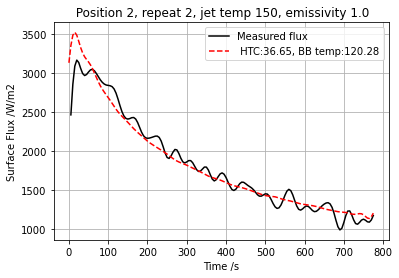

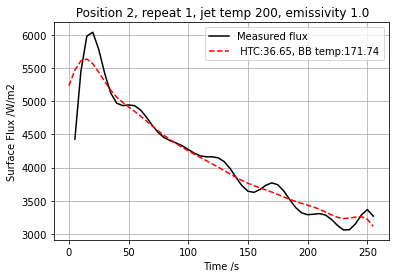

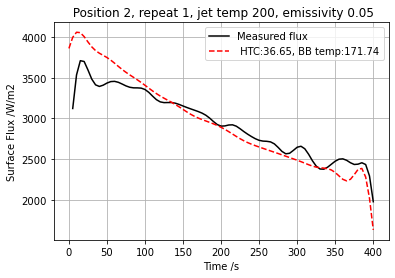

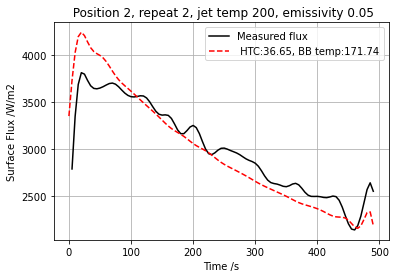

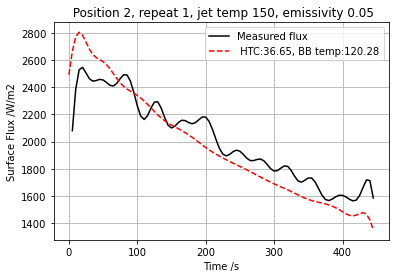

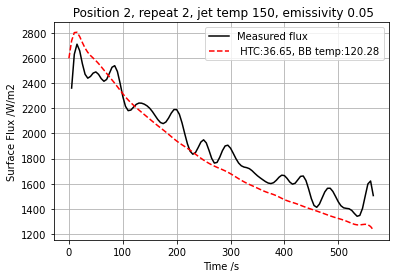

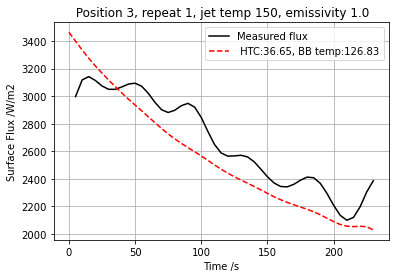

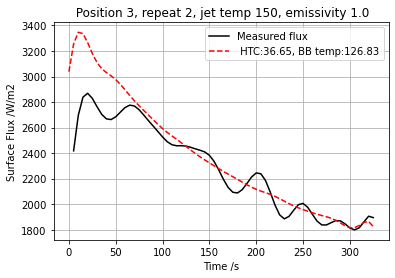

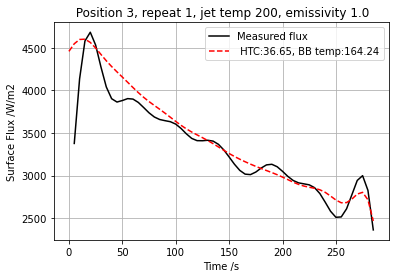

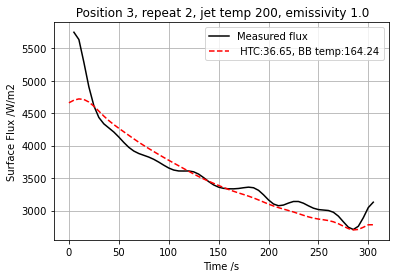

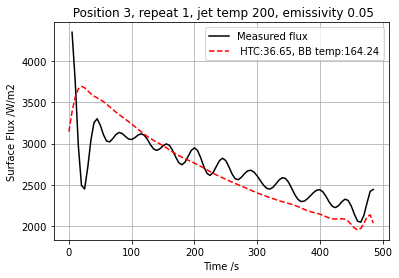

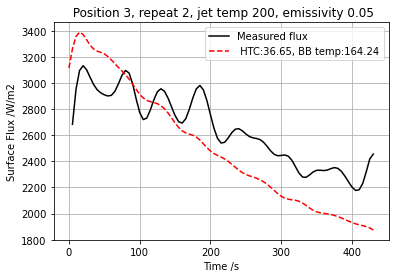

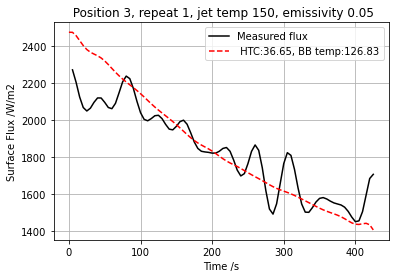

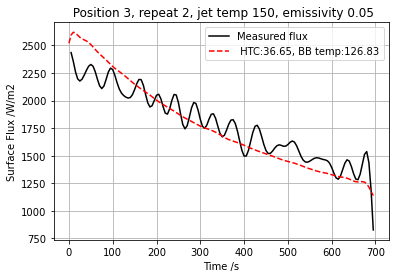

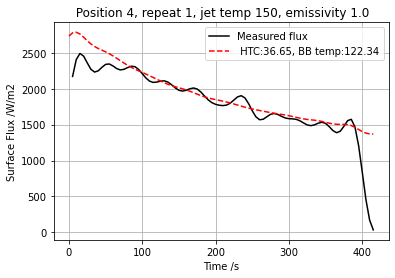

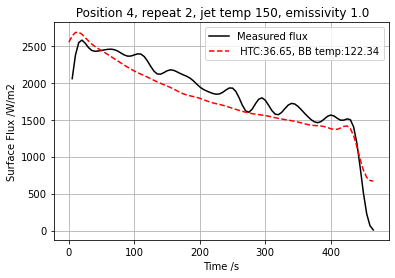

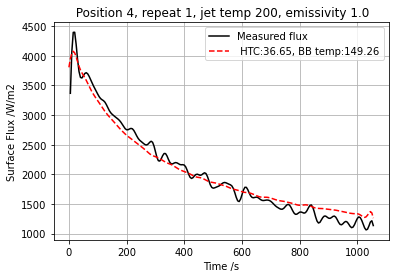

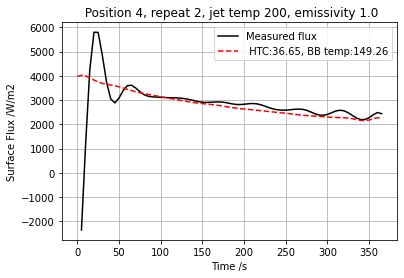

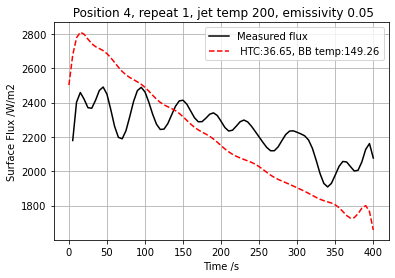

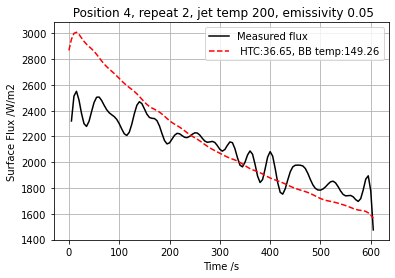

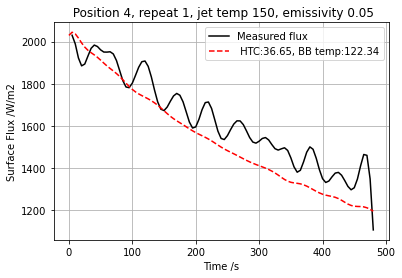

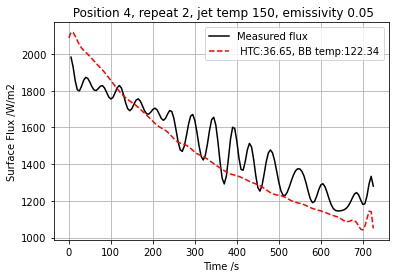

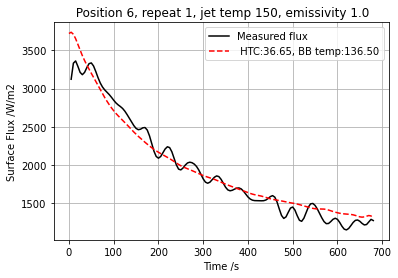

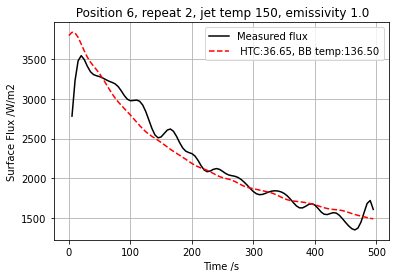

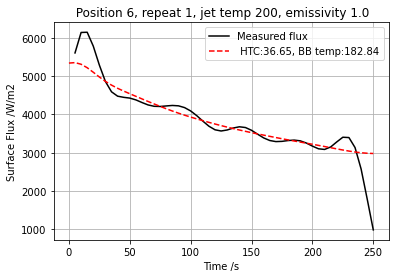

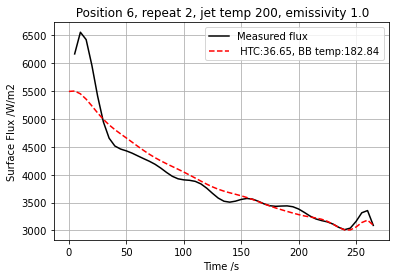

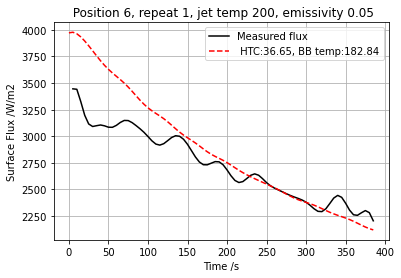

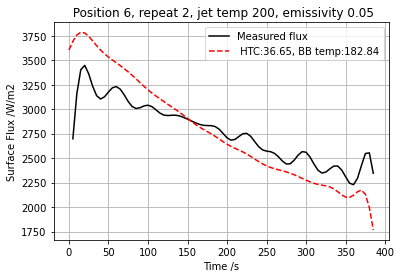

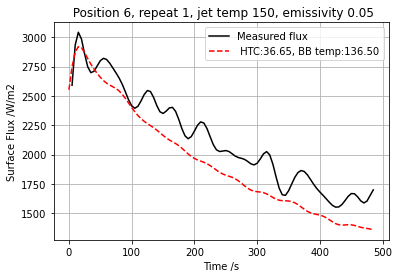

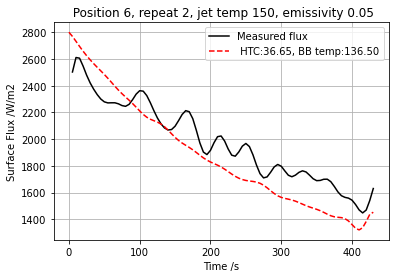

In [11]:
colors = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(dfs))))
i = 0
figs = []

ids = alldata['ID'].drop_duplicates().tolist()
for test_id in ids:
    test_id = int(test_id)
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]
    test_df = alldata[alldata['ID']==test_id]
    
    BB_temp = test_df['BB temp'].tolist()[0]
    HTC = test_df['fitted HTC'].tolist()[0]
    position = test_df['position'].tolist()[0]
    jet_temp = test_df['jet temp'].tolist()[0]
    repeat = test_df['repeat'].tolist()[0]
    emissivity = test_df['emissivity'].tolist()[0]
    
    label_string = f' HTC:{res[0]:.2f}, BB temp:{BB_temp:.2f}'
    title_string = f' Position {position}, repeat {repeat}, jet temp {jet_temp}, emissivity {emissivity}' 
    
    ax.plot(test_df['time'], test_df['flux'], label = "Measured flux", c='k', ls='-')
    ax.plot(test_df["time"], test_df['fitted surface flux'], c='r', ls='--', label = label_string)
    ax.set_title(title_string)
    i = i+1
    plt.legend()
    plt.xlabel('Time /s')
    plt.ylabel('Surface Flux /W/m2')
    #plt.xlim(0,400)
    #plt.ylim(0,2200)
    plt.grid()
plt.show()

In [9]:
px.scatter(alldata,x="fitted surface flux",y="flux", hover_data=["time","repeat","jet temp"], color="position")

In [10]:
test_averages = alldata.groupby(["ID"]).mean()
px.scatter(test_averages,x="fitted surface flux",y="flux", hover_data=["jet temp", "time"])

The flux model is validated below. The model is fitted on a random 60% sample of the data. This fitted model is then used to predict the surface flux of the test data not used for the fitting. The average difference between the modelled value and the measured value is then calculated for both data sets and added to the "metrics" dataframe

In [51]:
def surface_flux(df, sensor_information, boundary_TC):
    '''calculates the fitted convective and radiative fluxes into sensor, 
    returns a dataframe with those columns added'''
    df['fitted convective flux'] = df['fitted HTC']*(df[boundary_TC]-df[sensor_information[1][0]])
    df['fitted radiative flux'] = df["emissivity"]*5.670373*10**-8*\
    ((df['BB temp']+273.15)**4.0-(df[sensor_information[1][0]]+273.15)**4.0)
    df['fitted surface flux'] = df['fitted convective flux'] + df['fitted radiative flux']
    return df

def assign_parameters(params, df, train_temps):
    '''Inputs the fitting parameters into the dataframe'''
    df['fitted HTC'] = params[0]
    for i in range(len(train_temps)):
        temp = train_temps[i]
        BB_temp = params[i+1]
        df.loc[df['jet temp']==temp, 'BB temp'] = BB_temp
    return df

def residual(params, df, sensor_information, boundary_TC, flux, train_temps):
    df = assign_parameters(params, df, train_temps)
    df = surface_flux(df, sensor_information, boundary_TC)
    return np.sum((df['fitted surface flux'] - df[flux])**2.0)

def fitting_wrapper(train_set, sensor_information, boundary_TC, flux, train_temps, test_set):
    x0 = [30] + [180]*len(train_temps)
    bounds = [[0, 100]] + [[100,350]]*len(train_temps)
    result = opt.minimize(residual, x0, args=(train_set, sensor_information, boundary_TC, flux, train_temps), bounds=bounds)
    train_set = assign_parameters(result.x, train_set, train_temps)
    train_set = surface_flux(train_set, sensor_information, boundary_TC)

    test_set = assign_parameters(result.x, test_set, train_temps)
    test_set = surface_flux(test_set, sensor_information, boundary_TC)
    return result, train_set, test_set

def validation_wrapper(df, sensor_information, boundary_TC, flux):
    train_data, test_data, y_train, y_test = train_test_split(alldata, y, test_size=0.4)
    positions = train_data['position'].drop_duplicates().tolist()
    results = []
    test_sets = []
    train_sets = []
    for position in positions:
        train_set = train_data[train_data['position']==position]
        test_set = test_data[test_data['position']==position]
        train_temps = train_set['jet temp'].drop_duplicates().tolist()
        result, train_set, test_set = fitting_wrapper(train_set, sensor_information, boundary_TC, flux, train_temps, test_set)
        results.append(result)
        test_sets.append(test_set)
        train_sets.append(train_set)
    train_data = pd.concat(train_sets)
    test_data = pd.concat(test_sets)
    return train_data, test_data

def metric(df):
    return np.mean(np.sqrt((df["fitted surface flux"]-df["flux"])**2))


repeats = 10
train_metrics = []
test_metrics = []
for x in range(0,repeats):
    train_data, test_data = validation_wrapper(alldata, sensor_information, boundary_TC, "flux")
    train_metrics.append(metric(train_data))
    test_metrics.append(metric(test_data))
metrics = pd.DataFrame({"training metric":train_metrics,"testing metric":test_metrics})

In [52]:
metrics

training metric  testing metric
0       147.777198      149.223293
1       152.551818      146.201634
2       149.564456      146.210107
3       150.475790      148.277388
4       148.407984      150.447275
5       143.474878      152.299504
6       145.224408      152.031343
7       153.591222      145.560889
8       146.068453      150.228331
9       152.631901      144.888737

The metrics dataframe shows that the fit for the training and test data set is very similar, indicating that the flux model captures the data accurately